In [1]:
import pandas as pd
import pandas_market_calendars as mcal
import datetime
from Tools.Trade_Functions import *
import numpy as np
import plotly.express as px


In [2]:
def pick_trade(RunDate,NumStocks,stopLoss=-0.01,holdTime=0,TimeInput=5,debug=False):
    #Calculate pct change
    PctChange = get_SortedPctChange(RunDate,TimeInput,debug=debug)
    
    #select first N stocks and caculate percent retruns
    LongStockList = PctChange["Ticker"].iloc[:NumStocks]
    LongReturns = getLongReturns(RunDate,LongStockList,stopLoss=stopLoss,holdTime=holdTime,debug=debug)
    
    #select bottom N stocks and caculate percent retruns
    ShortStockList = PctChange["Ticker"].iloc[len(PctChange["Ticker"])-NumStocks:]
    ShortReturns = getShortReturns(RunDate,ShortStockList,stopLoss=stopLoss,holdTime=holdTime,debug=debug)
    TotalReturn = sum(LongReturns) / NumStocks + sum(ShortReturns) / NumStocks
   # print(f"Date:{RunDate}, Long Stocks:{list(LongStockList)}, Short Stocks:{list(ShortStockList)}, Return:{TotalReturn}\n")
    return TotalReturn

In [3]:
def calculate_mdd(return_vals):
    # Calculate the cumulative returns (wealth index)
    wealth_index = (1 + return_vals).cumprod()
    
    # Calculate the running maximum
    running_max = wealth_index.cummax()
    
    # Calculate drawdowns (difference between running max and current value)
    drawdowns = (wealth_index - running_max) / running_max
    
    # The maximum drawdown is the largest negative drawdown (i.e., most significant loss)
    mdd = drawdowns.min()  # This will give the maximum drawdown (most negative value)
    
    return mdd

In [4]:
framedCal= get_calendar()

In [23]:
TotalReturnList = list()
DateReturnList = list()
TimeInput = 2
NumStocks= 15
holdTime=5

cal=list()
for i in range(0,len(framedCal),holdTime):
    cal.append(framedCal[i])

#Anual Range
year=2024
yearlyDates = [date for date in cal if date.startswith(str(year))]
#yearlyDates_15 = [date for date in cal if date.startswith(str(2015))]
#yearlyDates_24 = [date for date in cal if date.startswith(str(2024))]

DateRange = [yearlyDates[0], yearlyDates[-1]]

#Set custome Range
#DateRange=['2015-01-02','2024-11-07']

DateRange=[cal.index(DateRange[0]),cal.index(DateRange[1])]
for day in cal[DateRange[0]:DateRange[1]]:
    dailyReturn = pick_trade(RunDate=day,NumStocks=NumStocks,stopLoss=-0.01,TimeInput=TimeInput,holdTime=holdTime,debug=False)
    TotalReturnList.append(dailyReturn)
    

returnDf = pd.DataFrame({'Date': pd.to_datetime(cal[DateRange[0]:DateRange[1]]),'Return':TotalReturnList})


M = 1
returnVal=[]
for i in returnDf["Return"]:
    M = M*(1+i)
    returnVal.append(M)
returnDf=pd.concat([returnDf,pd.DataFrame({"ReturnVals":returnVal})],axis=1)





In [24]:
returnDf

,Date,Return,ReturnVals
0,2024-01-08,0.037376,1.037376
1,2024-01-16,0.000621,1.038021
2,2024-01-23,0.020090,1.058875
3,2024-01-30,0.022154,1.082334
4,2024-02-06,0.066487,1.154295
5,2024-02-13,-0.000091,1.154190
6,2024-02-21,-0.001208,1.152796
7,2024-02-28,0.028557,1.185717
8,2024-03-06,0.029305,1.220465
9,2024-03-13,0.004711,1.226215


In [25]:

fig = px.line(returnDf, x='Date', y='ReturnVals')

fig.update_layout(title='Returns Over Time',
                  xaxis_title='Date',
                  yaxis_title='Price')

fig.show()

In [8]:

returnDf_2019 = returnDf[returnDf['Date'].dt.year == 2019]

# Ensure 'Return' is numeric
returnDf_2019['Return'] = returnDf_2019['Return'].astype(float)

/var/folders/5h/lv_gm99s337dww6tj437kv080000gn/T/ipykernel_87444/1417967852.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
np.prod(1 + returnDf_2019['Return'])

2.0037600113951135

In [10]:
SharpeRatio = ( np.mean(returnDf["Return"]) * 252 - 0.05) / (np.std(returnDf["Return"]) * 252**0.5)

In [11]:
SharpeRatio

9.331146274822023

In [12]:
print(np.mean(returnDf["Return"][returnDf["Return"]<0]))
len(returnDf["Return"][returnDf["Return"]<0])

-0.014663343198588922


143

In [13]:
print(np.mean(returnDf["Return"][returnDf["Return"]>0]))
len(returnDf["Return"][returnDf["Return"]>0])

0.03236137708316171


353

In [26]:
np.std(returnDf["Return"])*np.sqrt(252)

0.33853345734597035

In [14]:
#dfOut.to_csv("ReturnData.csv")


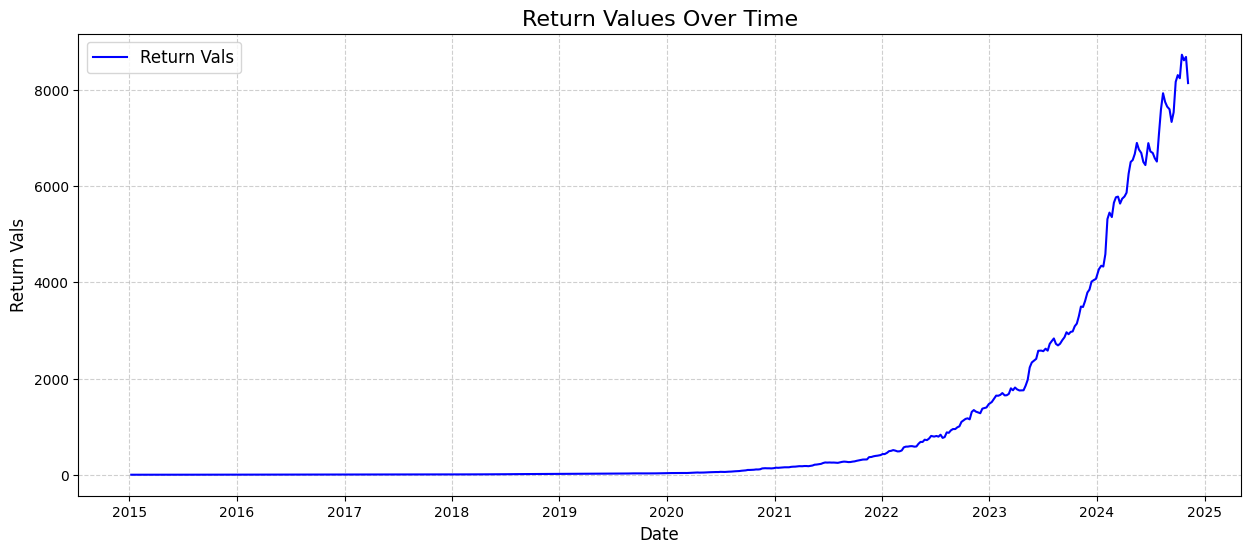

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))  # Set the figure size
plt.plot(returnDf['Date'], returnDf['ReturnVals'],  linestyle='-', color='blue', label="Return Vals")
plt.title("Return Values Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Return Vals", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.savefig("returns.png", dpi=300, bbox_inches='tight')

# Show the plot (optional)
plt.show()